<a href="https://colab.research.google.com/github/monroews/Hydraulics/blob/master/OStaRS_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Open Stacked Rapid Sand Filter Design

This design is dominated by the need to ensure equal flow distribution between filters, between layers, and within each layer. 

Flow distribution between sand layers has been a limiting factor for the StaRS design because the Trunks have different number of elbows and because the Backwash Trunk has been designed to be larger than the other trunks. We had to use very small head loss in the trunks in order to maintain reasonable flow distribution. This suggests an alternate design strategy for filters.

 1) Set the minor loss coefficients on the inlet trunks so that the head loss during filtration is the same for all of the trunks. This requires that the minor loss coefficients for the outer trunks be greater than the minor loss coefficient for the inner trunks. Use orifices near the inlets of the trunks to adjust the minor loss coefficients.
 1) Flow uniformity during filtration is thus no longer a constraint!
 1) New constraint is the amount of head we are willing to use to backwash the filter.
 1) Maximize flow for a given trunk size by minimizing minor losses in the inner two inlet trunks. Do this by having those trunks only have one elbow. Need to redesign inlet and outlet system to accomodate this.

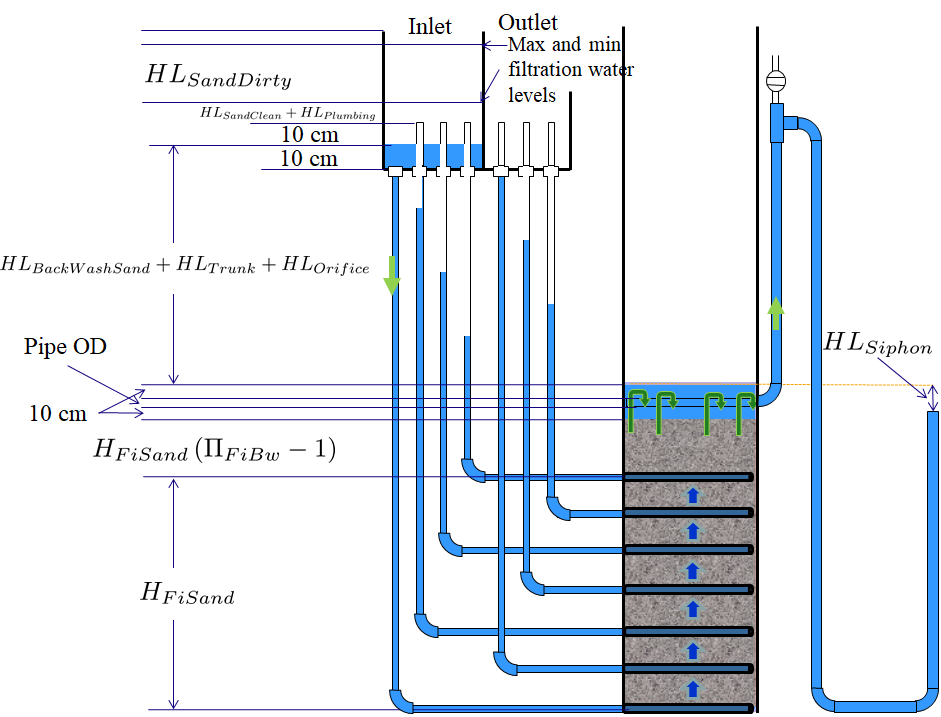

In [0]:
!pip install aguaclara

In [0]:
# imports
from aguaclara.core.units import unit_registry as u
import aguaclara as ac
from aguaclara.design.component import Component
import numpy as np
import matplotlib.pyplot as plt



# clean bed head loss (required for flow distribution calculations)
def Re_Ergun(v_a, D_Sand, Temperature, Porosity):
  return (v_a*D_Sand/(ac.viscosity_kinematic(Temperature)*(1-Porosity))).to(u.dimensionless)

def f_Ergun(v_a, D_Sand, Temperature, Porosity):
  return 300/Re_Ergun(v_a, D_Sand, Temperature, Porosity) + 3.5

def hf_Ergun(v_a, D_Sand, Temperature, Porosity, L):
  return (f_Ergun(v_a, D_Sand, Temperature, Porosity)*L/D_Sand*v_a**2/(2*u.gravity)*(1-Porosity)/Porosity**3).to(u.m)





# Calculate Trunk Head Loss and Flow Ratios

# Filter backwash head loss

$$h_{l_{FiBw}} = H_{Sand} \left( 1 - \phi_{Sand} \right)  \left( \frac{\rho_{Sand}}{\rho_{Water}} - 1 \right)$$



In [0]:
def Drain_D(Drain_t, Tank_A, Tank_H,K_e):
  Drain_D = ((8*Tank_A)/(np.pi * Drain_t))**(1/2) * ((Tank_H * K_e)/(2*u.gravity))**(1/4)
  return Drain_D.to(u.m)

print(Drain_D(1*u.min,2 * u.m**2,2*u.m,2))

0.1958 meter


# Tank drain function 

Should be added to physchem!
$$ D_{Pipe} = \sqrt{ \frac{8 A_{Tank} }{\pi t_{Drain}}} {\left( \frac{H_{Tank} \sum K_{e}}{2g} \right)^{\frac{1}{4}}}$$

We will need this to design the siphon. The siphon may deserve a more complete analysis given that it has the complication of continuous flow into the filter box while the siphon is draining.

# Siphon orifice design

$$ A_{orifices} = N \frac{\pi}{4}d_{orifices}^2 = \frac{\pi}{4 \Pi_{vc}}d_{siphon}^2 $$

The maximum number of orifices we can place in one row is

$$ N = \frac{Filter_W}{d_{orifices}+ S_{orifices}} $$

Eliminate N

$$ \frac{Filter_W}{d_{orifices}+ S_{orifices}} \frac{\pi}{4}d_{orifices}^2 = \frac{\pi}{4 \Pi_{vc}}d_{siphon}^2 $$

write in quadratic equation form

$$0 =Filter_W \Pi_{vc}d_{orifices}^2 - d_{siphon}^2 d_{orifices} - d_{siphon}^2 S_{orifices}$$

# Manifold and Port Velocity for flow distribution in branches

Relationship between port and manifold velocity and flow distribution
$$   \bar v_{M_1}= 2\sqrt{g (h_{e_{port}} + h_{l_{series}})\frac{1 - \Pi_{Q}^2}{\Pi_{Q}^2 + 1}}$$

We also need a solution for the required port head loss given a desired velocity in the manifold

Relationship between port and manifold velocity and flow distribution
$$  h_{e_{port}} =  \frac{\bar v_{M_1}^2}{4g}\frac{\Pi_{Q}^2 + 1}{1 - \Pi_{Q}^2} - h_{l_{series}}$$



Orifice design for outer inlet trunks to match head loss during filtration

$$ K_e = \left( \frac{A_{out}}{A_{in}} - 1 \right)^2 $$

The expanded area $A_{out}$ is the trunk inner area. The contracted area, $A_{in}$, is $A_{or} \Pi_{vc}$. Now we solve for area of the orifice, $A_{or}$.

$$ \sqrt{K_e} + 1 = \frac{A_{out}}{A_{or} \Pi_{vc}}  $$

$$A_{or} = \frac{A_{out}}{\Pi_{vc}\left(\sqrt{K_e} + 1 \right)}  $$
THis will enable us to estimate the size of the orifice that needs to be placed at the entrance of the top and bottom inlet trunks.
$$d_{or} = \frac{ID{trunk}}{\sqrt{\Pi_{vc}\left(\sqrt{K_e} + 1 \right)}}  $$

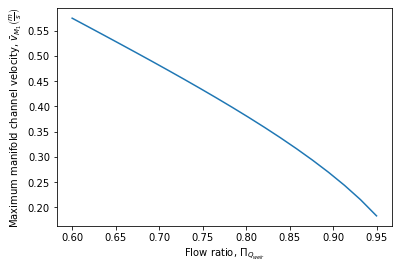

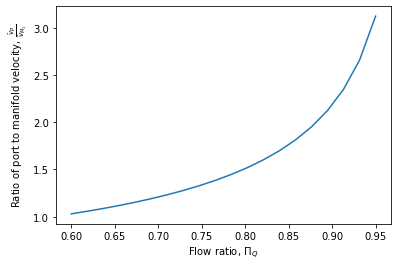

In [0]:
def Backwash_HL(H,Porosity,Temperature,Sand_Density):
  return H*(1-Porosity)*(Sand_Density/ac.density_water(Temperature)-1)

def Inlet_Channel_V_Max(H_weir,Ratio_Flow):
  return (2 * np.sqrt(u.gravity*H_weir*(1-Ratio_Flow**(2/3))/(1+Ratio_Flow**(2/3)))).to(u.m/u.s)

Ratio_Q_graph = np.linspace(0.6,0.95,20)

H_weir = 5 * u.cm
v_graph = np.empty_like(Ratio_Q_graph) * u.m/u.s
for i in range(20):
  v_graph[i] = Inlet_Channel_V_Max(H_weir,Ratio_Q_graph[i])

plt.plot(Ratio_Q_graph,v_graph)
plt.xlabel(r'Flow ratio, $\Pi_{Q_{weir}}$')
plt.ylabel(r'Maximum manifold channel velocity, $ \bar v_{M_1} \left(\frac{m}{s} \right)$')
plt.show()


def Ratio_Pipe_Manifold_V_Port_to_V_Man(Ratio_Flow):
  return np.sqrt((Ratio_Flow**2 + 1)/(2*(1-Ratio_Flow**2)))

Ratio_V_graph = np.empty_like(Ratio_Q_graph)
for i in range(20):
  Ratio_V_graph[i] = Ratio_Pipe_Manifold_V_Port_to_V_Man(Ratio_Q_graph[i])

plt.plot(Ratio_Q_graph,Ratio_V_graph)
plt.xlabel(r'Flow ratio, $\Pi_{Q}$')
plt.ylabel(r'Ratio of port to manifold velocity, $ \frac{\bar v_{P}}{\bar v_{M_1}}$')
plt.show()


In [0]:
class Manifold(): 
 """Design a Pipe manifold with Outlets.
 This object must be initialized with all relevant design inputs defined. All calculations are done on initialization.
 This designs a manifold diameter given the port head loss.
    
 Design Inputs:
   - ``Port_S (float * u.cm)``: port spacing (recommended, defaults to 10 * u.cm)
   - ``Manifold_SDR``: standard diameter ratio of the manifold pipe (recommended, defaults to 41 * u.dimensionless)
   - ``Port_vena_contracta``: the ratio of the port area to the contracta flow area (recommended, defaults to the vena contracta for an orifice)
   - ``Manifold_L``: the length of the manifold (approximately equal to Port_S * Port_N for single sided ports )
   - ``K``: minor loss coefficient
 """
 
 def __init__(self,q=50*u.L/u.s, Port_H_e=10*u.cm, Port_H_l_series=0 * u.cm, Ratio_Qp_Min=0.8, Port_S = 10 * u.cm,Port_vena_contracta=ac.VC_ORIFICE_RATIO,Pipe_SDR=41,Pipe_L=1 * u.m,Pipe_ND_Max=8*u.inch,doublesided=False, K=1, Pipe_ND_Min=1*u.inch, **kwargs):
   self.q=q
   #head loss from expansion after flowing through port
   self.Port_H_e=Port_H_e
   # head loss downstream from the expansion that is in series and thus contributes to improved flow distribution
   self.Port_H_l_series = Port_H_l_series
   self.Ratio_Qp_Min=Ratio_Qp_Min
   self.Port_S = Port_S
   self.Port_vena_contracta = Port_vena_contracta
   self.Pipe_SDR = Pipe_SDR
   self.Pipe_L = Pipe_L
   self.Pipe_ND_Max = Pipe_ND_Max
   self.doublesided = doublesided
   self.K = K
   self.Pipe_ND_Min = Pipe_ND_Min
   self.calculate_outputs()

   
   #self.subcomponents = [self.Manifold]

   #super().__init__(**kwargs)
   #super().set_subcomponents()
       
 def calculate_outputs(self):
   # port velocity is based on the head loss through the port. We may need to extend this to the case when there are multiple head loss elements in series.
   self.Port_V = (np.sqrt(2*u.gravity*self.Port_H_e)).to(u.m/u.s)
   self.Pipe_V_max = (2 * np.sqrt(u.gravity*(self.Port_H_e + self.Port_H_l_series)*((1-self.Ratio_Qp_Min**2)/(self.Ratio_Qp_Min**2 + 1)))).to(u.m/u.s)
   self.Pipe_Q_Max = (ac.area_circle(ac.ID_SDR(self.Pipe_ND_Max,self.Pipe_SDR))*self.Pipe_V_max).to(u.L/u.s)
   #The following line of code adds 1.5 inch as an available pipe size. This can be deleted after the list of available pipe sizes is corrected.
   self.ND_all_pipes = np.insert(ac.ND_all_available().magnitude, 2, 1.5)*u.inch
   # maximum length of the pipe assuming flow per length of pipe is a constant and using the maximum pipe size
   self.Pipe_L_Max = (self.Pipe_Q_Max * self.Pipe_L/self.q).to(u.m)
   self.Pipe_A_min = (self.q / self.Pipe_V_max).to (u.m**2) 
   self.Pipe_ID_min = ac.ceil_nearest(ac.diam_circle(self.Pipe_A_min), ac.ID_SDR_all_available(self.Pipe_SDR))
   self.Pipe_ND = ac.max(ac.ND_SDR_available(self.Pipe_ID_min,self.Pipe_SDR),self.Pipe_ND_Min)
   self.Pipe_ID = ac.ID_SDR(self.Pipe_ND,self.Pipe_SDR)
   self.Pipe_OD = ac.OD(self.Pipe_ND)
   self.Pipe_V = (self.q/ac.area_circle(self.Pipe_ID)).to(u.m/u.s)
   self.Port_N = self._Port_N()
   self.Port_Q = self.q/self.Port_N
   self.Port_D = (ac.diam_circle(self.Port_Q/self.Port_V /self.Port_vena_contracta)).to(u.mm)
   self.H_e = (ac.headloss_exp(self.q, self.Pipe_ID, self.K)).to(u.cm)
   

 def _Port_N(self):
   Port_N = np.trunc((self.Pipe_L/self.Port_S).to(u.dimensionless))
   if self.doublesided:
     Port_N *= 2
   return Port_N.to(u.dimensionless).magnitude

 

Trunk = Manifold(q=20*u.L/u.s,Port_H_e=10*u.cm, Port_H_l_series=10*u.cm,Ratio_Qp_Min= 0.9,Port_S=10*u.cm,Pipe_L = 1 * u.m, doublesided = True,Port_vena_contracta = 1)
print(Trunk.Port_N)
print(Trunk.Port_S)
print(Trunk.Port_D)
print(Trunk.Pipe_ND)
print(Trunk.q)
print(Trunk.Pipe_V)
print(Trunk.Pipe_Q_Max)
print((Trunk.Pipe_V**2/(2*u.gravity)).to(u.cm))


20.0
10 centimeter
30.15 millimeter
8 inch
20 liter / second
0.5864 meter / second
30.95 liter / second
1.753 centimeter


In [0]:
"""The filter box contains the sand, inlet and outlet piping, and the backwash siphon
It would be good to standardize the following design so that 
components would be at least somewhat interchangeable between projects. 
Weir gate sizes, weir slot width, branch lengths, etc could all be standardized."""

class OStaRSBox():
 """Design an AguaClara Open Stacked Rapid Sand Filter box
 Datum for the OStaRS is the design flow water level in the inlet Channel.
 This design assumes that the Inlet Trunks will only have one elbow. 
 This requires a redesign of the inlet and outlet boxes

 Design Inputs:
   - ``q (float * u.L/u.s)``: Flow rate (required)
   - ``temp (float * u.degC)``: Water temperature (optional, defaults to
     20°C)
    """

 def __init__(self, q=50*u.L/u.s, temp=20*u.degC, Ratio_Qp_Min=0.85, Ratio_QFi_Min=0.95, Ratio_QBw_min=0.80, Datum_z=0*u.m,Trunk_ND_Max=8 * u.inch,Layer_H_Min=20*u.cm, Sand_D60=0.8 * u.mm,Trunk_BW_HL_Max = 50 * u.cm,**kwargs):
   # The flow is the flow for all of the filters.
   self.q=q
   self.temp=temp
   # ratio of min port flow over max port flow (manifold port flow uniformity measure)
   self.Ratio_Qp_Min=Ratio_Qp_Min
   # head loss over the weir from the inlet channel
   self.Inlet_Weir_H = 5 * u.cm
   # ratio of min filter flow over max filter flow
   self.Ratio_QFi_Min = Ratio_QFi_Min
   # ratio of minimum backwash flow to design backwash flow
   self.Ratio_QBw_min = Ratio_QBw_min
   # It should be possible to set Orifice head loss during backwash to between 10 and 20 cm. 
   # This will increase the flow rate that we can send through a manifold pipe.
   # The datum is the height of water under design flow in the filter inlet channel
   self.Datum_z = Datum_z
   self.Trunk_ND_Max = Trunk_ND_Max
   self.Layer_H_Min = Layer_H_Min
   self.Trunk_BW_HL_Max = Trunk_BW_HL_Max
   
   # set branch spacing to give reasonable flow distribution in sand
   self.Branch_S = self.Layer_H_Min/2
   self.temp_Max = 30 * u.degC
   self.Backwash_V = 11 * u.mm/u.s
   self.Layer_N = 6

   # minimum spacing between trunks where they pass through the concrete wall
   self.Trunk_S_Min = 3 * u.cm
   
   self.Sand_Density = 2650 * u.kg/u.m**3
   self.Filter_Max_HL = 80 * u.cm 
   self.Filter_N_Min = 2
   # time for the air to vent out of the siphon pipe
   self.Siphon_Vent_t = 15* u.s
   
   self.Sand_D60 = Sand_D60
   self.Sand_Porosity = 0.4
   

   # Would it be better to assign these values directly to the subcomponents? I can't do that with the way this code is organized since the manifold doesn't update if new values are sent to it.
   

   self.Orifice_S = 5 * u.cm
   self.Trunk_SDR = 26
   self.Branch_SDR = 26
   self.Branch_Fi_ND = 1 * u.inch
   self.Branch_Bw_ND = 1.5 * u.inch
   self.Branch_SDR = 26
   self.Branch_S = 10 * u.cm
   #Estimate the length of the backwash trunk pipe
   self.Trunk_BW_L = 6 * u.m
   # Calculate these minor loss coefficients based on fittings and orifices.
   #self.Trunk_Outer_K_e = ac.PIPE_ENTRANCE_K_MINOR + 1*ac.EL90_K_MINOR
   
   # The entrance losses for the filtration trunks is 1 because of the pipe stub
   # I assume here tha twe will redesign the flow paths so that the inner inlet trunks only have one elbow
   # These loss coefficients needs to be reviewed after the Onshape design is updated.
   # might be worthwhile adding a correction for pipe length which will be a function of the diameter.
   # the Inner and Outer designation are both for INLET trunks
   self.Trunk_Inner_K_e = 1 + 1*ac.EL90_K_MINOR
   # Set head loss in Outer Trunks to be identical to inner trunks by having 4 times the minor loss coefficient
   self.Trunk_Outer_K_e = 4*self.Trunk_Inner_K_e
   # We need to add some additional minor loss to the outer two inlet pipes to guarantee uniform flow during filtration. 
   # This will result in a significant head loss in the inlet pipe during backwash
   self.Trunk_Outer_K_e_orifice = self.Trunk_Outer_K_e - (1 + 2*ac.EL90_K_MINOR)
   
   self.Trunk_Outlet_K_e = 1 + 2*ac.EL90_K_MINOR
   self.Branch_K_e = ac.PIPE_ENTRANCE_K_MINOR
   self.Siphon_K_e = ac.PIPE_ENTRANCE_K_MINOR + 3*ac.EL90_K_MINOR + ac.TEE_FLOW_BR_K_MINOR +ac.PIPE_EXIT_K_MINOR
   self.Siphon_Orifice_S = 1 * u.cm
   self.Freeboard = 10 * u.cm
   self.calculate_outputs()

 def _Siphon_Orifice_D(self):
   #Calculate the orifice diameter assuming the orifice area = pipe area
   # Orifices have a spacing between openings of Siphon_Orifice_S
   # see Latex equation derivation above!

   a = ac.VC_ORIFICE_RATIO * self.Filter_W
   b = -self.Siphon_ID**2
   c = b*self.Siphon_Orifice_S
   x = (-b+np.sqrt(b**2 - (4*a*c)))/(4*a)
   return x.to(u.cm)

    
 def calculate_outputs(self):
   self.Filter_V = self.Backwash_V/self.Layer_N
   
   # Calculate arrays of trunk diameters
  
   self.Trunk_ND_array = np.flip(ac.ND_all_available())
   self.Trunk_ND_array =+ self.Trunk_ND_array[self.Trunk_ND_array<=self.Trunk_ND_Max] 
   self.Trunk_ND_array =+ self.Trunk_ND_array[self.Trunk_ND_array>1*u.inch] 

   #Calculate arrays of corresponding sand layer depths, filter clean bed head loss, max flows
   
   # correct the depth of the fluidized sand based on the OD of the trunks
   # make all of the layers the same depth! 
   # Set the sand depth to the max of the user specified depth and the depth required for the trunks.
   self.Layer_H_array = np.zeros(np.size(self.Trunk_ND_array)) * u.cm
   self.Trunk_OD_array = np.zeros(np.size(self.Trunk_ND_array)) * u.cm
   self.Trunk_ID_array = np.zeros(np.size(self.Trunk_ND_array)) * u.cm
   self.Trunk_H_L_Max_array = np.zeros(np.size(self.Trunk_ND_array)) * u.cm
   self.Filter_Q_Max_array = np.zeros(np.size(self.Trunk_ND_array)) * u.L/u.s
   self.Filter_N_Min_array = np.zeros(np.size(self.Trunk_ND_array))
   self.Sand_Clean_HL_array = np.zeros(np.size(self.Trunk_ND_array)) * u.cm
   self.Filter_N_array = np.zeros(np.size(self.Trunk_ND_array))
   for i in range(np.size(self.Trunk_ND_array)):
     self.Trunk_ID_array[i] = ac.ID_SDR(self.Trunk_ND_array[i],self.Trunk_SDR)
     self.Trunk_OD_array[i] = ac.OD(self.Trunk_ND_array[i])
     self.Layer_H_array[i] = (ac.ceil_step(ac.max(self.Layer_H_Min, self.Trunk_OD_array[i] + self.Trunk_S_Min),1*u.cm))
     self.Sand_Clean_HL_array[i] = hf_Ergun(self.Filter_V, self.Sand_D60, self.temp_Max, self.Sand_Porosity, self.Layer_H_array[i])
     
     self.Filter_Q_Max_array[i] = ac.flow_pipeminor(self.Trunk_ID_array[i], self.Trunk_BW_HL_Max, self.Trunk_Outer_K_e)
     self.Filter_N_array[i] = self.q/self.Filter_Q_Max_array[i]
   
   self.My_i = np.where(self.Filter_N_array == ac.floor_nearest(self.Filter_N_Min,self.Filter_N_array))[0][0]
   if self.Filter_N_array[0] >= self.Filter_N_Min:
     self.My_i = 0
   
   
   self.Trunk_ID = self.Trunk_ID_array[self.My_i]
   self.Trunk_ND = self.Trunk_ND_array[self.My_i]
   self.Trunk_OD  = self.Trunk_OD_array[self.My_i]
   self.Layer_H = self.Layer_H_array[self.My_i]
   self.Sand_Clean_HL = self.Sand_Clean_HL_array[self.My_i]
   self.Filter_Q_Max = self.Filter_Q_Max_array[self.My_i]
   self.Filter_N = np.maximum(np.ceil(self.Filter_N_array[self.My_i]),self.Filter_N_Min)
   self.Filter_Q = self.q/self.Filter_N
   self.Filter_active_A = (self.Filter_Q/self.Backwash_V).to(u.m**2)
   self.Trunk_Inner_Q = 2 * self.Filter_Q/self.Layer_N
   self.Trunk_Outer_Q = self.Filter_Q/self.Layer_N
   self.Fluidize_Sand_HL = (self.Layer_H*(1-self.Sand_Porosity)*(self.Sand_Density/ac.density_water(self.temp)-1)).to(u.m)
   
   # Calculate the diameter of the orifices that we may place at the inlet to the top and bottom inlet Trunks to ensure uniform flow distribution during filtration
   self.Trunk_Outer_Orifice_D = self.Trunk_ID/(np.sqrt(ac.VC_ORIFICE_RATIO*(np.sqrt(self.Trunk_Outer_K_e_orifice)+1)))
   
   # calculate the total orifice area on the branches to obtain uniform flow distribution out of the orifices during backwash
   # These orifices are what create uniform flow distribution between branches and then between orifices
   # We use the manifold to port velocity ratio to obtain the port velocity
   self.Trunk_Outer_BW_V = self.Filter_Q/ac.area_circle(self.Trunk_ID)
   self.Orifice_Contracted_V = self.Trunk_Outer_BW_V * Ratio_Pipe_Manifold_V_Port_to_V_Man(self.Ratio_Qp_Min)
   
   self.Orifice_V = ac.VC_ORIFICE_RATIO * self.Orifice_Contracted_V
   # Total area of orifices in the outer manifolds
   self.Orifice_Outer_A = self.Filter_Q/self.Orifice_V
   # Here we assume that the trunk lines that feed two layers have twice as many orifices as the top and bottom trunk lines so that the orifice head loss the same for all inlets. 
   # It is possible that we will use this same orifice configuration for outlet manifolds as well
   # The orifice head loss is the head loss that we would obtain if the flow divided uniformly between sand layers. This does not account for the lack of uniform flow division.
   
   self.Orifice_BW_HL = (self.Orifice_Contracted_V**2/(2*u.gravity)).to(u.cm)

   # The head loss through the branch orifices during filtration is less than the head loss during backwash by a factor of 36.
   self.Orifice_Fi_HL = (1/self.Layer_N)**2 * self.Orifice_BW_HL

   # calculate the total depth of the sand bed
   self.Sand_to_fluidize_H = self.Layer_H*(self.Layer_N)

   # how much width on average is occupied by trunks and hence how much additional width should be added to the filter? 
   # Assume that 6 trunks are in the sand bed because the top of the top trunk and the bottom of the bottom trunk are not in the active sand bed.
   self.Trunk_W = ac.area_circle(self.Trunk_OD)/self.Layer_H

   #set filter plan view dimensions somewhat arbitrarily. 
   # Set filter width to be a constant to make fabrication more consistent?
   # This width needs careful analysis and should be set with an algorithm that is a function of the filter area.
   # Clearly a constant isn't adequate!
   # The filter must be wide enough to accomodate the inlet box, the overflow box, and access between pairs of filters
   self.Filter_W = 1.5* u.m
   # Perhaps this should be optimized to reduce the amount of walls required. 
   # More likely the Filter width can be optimzed based on inlet and outlet control box requirements. Goal would be to keep the control system as compact as possible.
   # The limitation is most likely the distance required for the double elbows required to get all the inlets and outlets into a straight line going into the filter. 
   self.Filter_active_W = self.Filter_W - self.Trunk_W
   self.Filter_L = self.Filter_active_A/self.Filter_active_W
   self.Filter_A = self.Filter_L * self.Filter_W
   self.Sand_Volume = (self.Filter_active_A * self.Sand_to_fluidize_H).to(u.m**3)
   self.Sand_Mass = (self.Sand_Volume * self.Sand_Density * self.Sand_Porosity).to(u.kg)

   # design backwash branches
   # the length of a branch is equal to half the width of the filter. We ignore the fact that the trunk takes up space at this stage
   # maybe we should be designing branches to be UNDERNEATH the trunks and connect to the trunk with a Tee.
   # The flow through a branch can be calculated precisely (without worrying about the extra width we added to the filter to compensate for the trunks) 
   # by first figuring out how many branches there are in one layer and assuming double sided (branches leaving on both sides from the trunk)
   self.Branch_Layer_N = 2*self.Filter_L/self.Branch_S

   self.Branch_Bw_Q = self.Filter_Q/self.Branch_Layer_N
   self.Branch_Bw=Manifold(q=self.Branch_Bw_Q, Port_H_e=self.Orifice_BW_HL, Port_H_l_series=0*u.cm, Ratio_Qp_Min=self.Ratio_Qp_Min, Port_S=self.Orifice_S, Port_vena_contracta=ac.con.VC_ORIFICE_RATIO, Pipe_SDR=self.Branch_SDR, Pipe_L=self.Filter_W/2, doublesided=False, K=self.Branch_K_e, Pipe_ND_Max=self.Branch_Bw_ND)
   # design filter branches for inner Trunks (and then we will use the same size for the two outer trunks)
   self.Branch_Fi_Q = 2* self.Branch_Bw_Q/self.Layer_N
   self.Branch_Fi=Manifold(q=self.Branch_Fi_Q, Port_H_e=self.Orifice_Fi_HL, Port_H_l_series=self.Sand_Clean_HL, Ratio_Qp_Min=self.Ratio_Qp_Min, Port_S=self.Orifice_S, Port_vena_contracta=ac.con.VC_ORIFICE_RATIO, Pipe_SDR=self.Branch_SDR, Pipe_L=self.Filter_W/2, doublesided=False, K=self.Branch_K_e)
   # need to calculate head loss through inlet piping
   # outlet piping should have the same head loss (assuming here that we are switching to gravity exclusion zones)
   self.Trunk_Inlet_Fi_HL = ac.headloss_exp(self.Trunk_Outer_Q, self.Trunk_ID, self.Trunk_Outer_K_e)
   self.Trunk_BW_HLe =  ac.headloss_exp(self.Filter_Q, self.Trunk_ID, self.Trunk_Outer_K_e)
   # need an estimate of the backwash trunk length to calculate total head loss
   # The 6 m is a guess. Fortunately the major losses are rather small
   
   self.Trunk_BW_HLef = ac.headloss(self.Filter_Q, self.Trunk_ID, self.Trunk_BW_L, ac.viscosity_kinematic(self.temp), ac.PVC_PIPE_ROUGH, self.Trunk_Outer_K_e)
   self.Trunk_Outlet_HL =  ac.headloss_exp(self.Trunk_Inner_Q, self.Trunk_ID, self.Trunk_Outlet_K_e)

   # Design the siphon pipe
   # We need to know the depth of water that needs to be flushed
   # see filter elevation diagram in Filtration powerpoint 
   # inlet head loss equals outlet head loss
   # Want 10 cm of freeboard both above and below the inlet box pipe stubs. This gives a factor of 2!
   # Calculate depth of water that must be refilled in the filter box to transition from backwash to filtration
   self.Post_Backwash_Fill_H = self.Fluidize_Sand_HL+ self.Trunk_BW_HLef + self.Orifice_BW_HL + self.Freeboard + self.Sand_Clean_HL + self.Trunk_Inlet_Fi_HL + self.Orifice_Fi_HL + self.Trunk_Outlet_HL
   self.Post_Backwash_Fill_Vol = self.Post_Backwash_Fill_H * self.Filter_A
   self.Pre_Backwash_Flush_H = self.Post_Backwash_Fill_H + (self.Filter_Max_HL - self.Sand_Clean_HL)
   self.Pre_Backwash_Flush_Vol = self.Pre_Backwash_Flush_H * self.Filter_A 
   # time for the siphon to drain the filter tank to begin backwash (should be a small fraction of the time required to fill box at backwash velocity)
   # This is because the filter box is filling with water at this rate constantly. This goal results in a very large diameter siphon pipe.
   # We need a new derivation of the drain pipe diameter equation that accounts for the constant flow of water into the filter
   # For now I've set the drain time (assuming no inflow!) to equal the time required to refill the filter box after backwash.
   self.Post_Backwash_Fill_t = (self.Post_Backwash_Fill_Vol / self.Filter_Q).to(u.s)
   self.Siphon_Drain_t = self.Post_Backwash_Fill_t
   # the factor of 2 is required because the average flow is 1/2 of the max while the filter box is draining. 
   # This is not quite right because of the constant flow of water into the filter.
   self.Siphon_Q_init = 2* (self.Post_Backwash_Fill_Vol/self.Siphon_Drain_t + self.Filter_Q)
   # Include an estimate of the length of the siphon pipe. 
   #This should be corrected based on the actual geometry of the filter
   self.Siphon_L_estimate = 10 * u.m
   self.Siphon_D_min = ac.diam_pipe(self.Siphon_Q_init,self.Pre_Backwash_Flush_H,self.Siphon_L_estimate,ac.viscosity_kinematic(self.temp),ac.PVC_PIPE_ROUGH,self.Siphon_K_e )

   self.Siphon_ND = ac.ND_SDR_available(self.Siphon_D_min,self.Trunk_SDR)
   self.Siphon_ID = ac.ID_SDR(self.Siphon_ND,self.Trunk_SDR)
   #Calculate steady state siphon head loss
   self.Siphon_Pipe_HL = ac.headloss(self.Filter_Q, self.Siphon_ID,self.Siphon_L_estimate,ac.viscosity_kinematic(self.temp),ac.PVC_PIPE_ROUGH, self.Siphon_K_e,)

   # design the orifices into the Siphon pipe. 
   #This is not a critical manifold design given the ease of flow distribution in the water above the fluidized sand. 
   #Thus simple set orifice area = pipe area
   # We assume that we can create a row of orifices the entire length of the siphon pipe manifold.
   self.Siphon_Orifice_D = self._Siphon_Orifice_D()
   self.Siphon_Orifice_N = ac.floor(self.Filter_W/(self.Siphon_Orifice_D + self.Siphon_Orifice_S))
   self.Siphon_Orifice_HL = ac.head_orifice(self.Siphon_Orifice_D,ac.VC_ORIFICE_RATIO,self.Filter_Q/self.Siphon_Orifice_N)
   self.Siphon_HL = self.Siphon_Pipe_HL + self.Siphon_Orifice_HL

   
   # Design the siphon air valve to break the siphon in about 10 seconds
   # Need an estimate of the volume of air in the siphon pipe
   self.Siphon_Air_Vol = 2*self.Post_Backwash_Fill_H * ac.area_circle(self.Siphon_ID)
   # the siphon air release time was set to 10 s in 2012. 
   self.Siphon_Air_t = 5 * u.s
   # initial air flow rate is double the final air flow rate because the head is decreasing almost to zero as the air vents.
   self.Siphon_Air_Q_init = 2* self.Siphon_Air_Vol/self.Siphon_Air_t
   # It is critical that the air be vented fast enough so that the flow of water starts quickly and completely purges the air from the pipe
   # The siphon break time at the end of backwash is not as critical as the time to initiate the siphon.
   # The air maintains the same pressure at both air water interfaces in the siphon pipe as the water level in the filter rises.
   # Thus the air pressure in the siphon pipe is 1/2 the difference in water elevation in the filter box. 
   # We use the difference between backwash and initiating filtration.

   self.Siphon_Air_HL = 1/2*self.Post_Backwash_Fill_H * ac.density_water(self.temp)/ac.density_air(u.atm, 29*u.g/u.mol, self.temp)
   self.Siphon_Air_Ke = 1.5
   self.Siphon_Air_D = ac.ND_SDR_available(ac.diam_pipeminor(self.Siphon_Air_Q_init,self.Siphon_Air_HL,self.Siphon_Air_Ke),26)

   # Need to know the top elevation of the siphon pipe relative to the backwash water elevation
   # We may want to increase the height of the top of the siphon pipe to prevent premature siphon air lock failure.There is some evidence that the siphon's may be failing too early sometimes. Need data!

   # Design the movable weir/gate to have less than 1 cm of head loss when the water level is equal to the top of the wide weir (zero flow going to the other filters)
   # This is not standard weir flow because it is flooded. Instead of the head loss being the height of water behind the weir, we have the head loss limited to perhaps 1 cm. 
   # We can model this as an orifice with 1 cm of head loss 
   # Our mathcad design limited this to 2 mm of head loss. I don't see any reason why we can't have a little more head loss. 
   # The tradeoff is that any head loss reduces the flow thru the slot to the filter in backwash. 
   # We correct this by making the slot weir deeper by the amount of the head loss through the gate weir.
   # With the gate open it is orifice flow and the unknown is the width of the weir
   # Assume the gate opening is 20 cm high
   self.Gate_Weir_H = 20 * u.cm
   self.Gate_Weir_HL_max = 1 *u.cm

   self.Gate_Weir_W = (self.Filter_Q/(ac.VC_ORIFICE_RATIO*self.Gate_Weir_H * np.sqrt(2*u.gravity*self.Gate_Weir_HL_max))).to(u.m)

   # Design the inlet weir width to give the target head loss
   self.Inlet_Weir_W = ac.width_rect_weir(self.Filter_Q,self.Inlet_Weir_H)
   # The slotted weir height (measured down from the water surface in the inlet channel at design flow)
   self.Slot_Weir_H = self.Inlet_Weir_H/(1-self.Ratio_QBw_min**(2/3)) + self.Gate_Weir_HL_max
   self.Slot_Weir_W = ac.width_rect_weir(self.Filter_Q,self.Slot_Weir_H)

   # ELEVATIONS
   #Calculate elevations using z_Datum as the design flow water surface in the inlet channel
   # The datum for the filter is the design flow water level in the inlet channel (Pay attention to this!)
   
   self.Inlet_Weir_Z = self.Datum_z - self.Inlet_Weir_H

   #Design width of Filter Influent channel
   self.Inlet_Chan_V = Inlet_Channel_V_Max(self.Inlet_Weir_H,self.Ratio_QFi_Min)
   self.Inlet_Chan_A = (self.q/self.Inlet_Chan_V).to(u.m**2)

   # sand drain pipe
   # Use the largest pipe that will fit between the branch lines (but not between the backwash branch lines)
   # The outlet should be right below the top inlet.


Trunk sizes [10.   8.   6.   4.   3.   2.   1.5] inch
Number of filters [ 2.11727697  3.28909483  5.57471715 12.08285531 19.97369959 43.37778525
 67.77778946]
Max Filter flow [56.67657168 36.48420197 21.52575579  9.93142738  6.00790051  2.76639297
  1.7704915 ] liter / second
The index of the Trunk array is 0
Maximum filter flow 56.68 liter / second
There are 3.0 filters with a flow of 40 liter / second each.
The nominal trunk diameter is 10 inch
The orifice diameter for the outer two inlet trunks is 17.78 centimeter
The sand layer depth is 31 centimeter
The total depth of sand to fluidize is 186 centimeter
The filter plan view ACTIVE area (not counting average area occupied by trunk lines) is 3.636 meter ** 2
The filter length is 2.774 meter
The Filter Width is 1.5 meter
The clean sand head loss is 5.964 centimeter
The head loss for Inlet Trunks during filtration is 0.006918 meter
The minor head loss for the bottom Inlet Trunk during backwash 0.249 meter
The total head loss for the bo

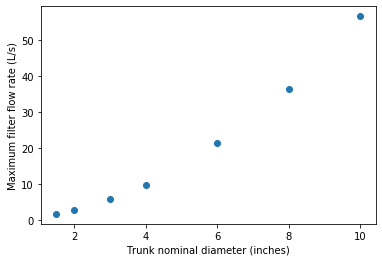

In [0]:
myFilter = OStaRSBox(q=120*u.L/u.s, Ratio_Qp_Min=0.80, Trunk_ND_Max=10*u.inch,Layer_H=20*u.cm,Sand_D60=0.825 * u.mm,Trunk_BW_HL_Max=50 * u.cm)
print('Trunk sizes', myFilter.Trunk_ND_array.magnitude,myFilter.Trunk_ND_array.units)
print('Number of filters',myFilter.Filter_N_array)

print('Max Filter flow', myFilter.Filter_Q_Max_array.magnitude,myFilter.Filter_Q_Max_array.units)
print('The index of the Trunk array is', myFilter.My_i)
print('Maximum filter flow',myFilter.Filter_Q_Max)
print('There are',myFilter.Filter_N,'filters with a flow of',myFilter.Filter_Q,'each.')
print('The nominal trunk diameter is',myFilter.Trunk_ND)
print('The orifice diameter for the outer two inlet trunks is',myFilter.Trunk_Outer_Orifice_D)
print('The sand layer depth is',myFilter.Layer_H)
print('The total depth of sand to fluidize is',myFilter.Sand_to_fluidize_H )
print('The filter plan view ACTIVE area (not counting average area occupied by trunk lines) is',myFilter.Filter_active_A)
print('The filter length is',myFilter.Filter_L)
print('The Filter Width is',myFilter.Filter_W)
print('The clean sand head loss is' ,myFilter.Sand_Clean_HL)
print('The head loss for Inlet Trunks during filtration is',myFilter.Trunk_Inlet_Fi_HL)
print('The minor head loss for the bottom Inlet Trunk during backwash',myFilter.Trunk_BW_HLe)
print('The total head loss for the bottom Inlet Trunk during backwash',myFilter.Trunk_BW_HLef)
print('The head loss for Outlet Trunks during filtration is',myFilter.Trunk_Outlet_HL)
print('The backwash orifice head loss is',myFilter.Orifice_BW_HL)
print('Backwash Branch max L',myFilter.Branch_Bw.Pipe_L_Max)
print('Backwash Branch nominal diameter is',myFilter.Branch_Bw.Pipe_ND)
print('Filter Branch nominal diameter is',myFilter.Branch_Fi.Pipe_ND)
print('Filter Branch actual maximum velocity is', myFilter.Branch_Fi.Pipe_V)
print('Port diameter on branches that serve two layers is',myFilter.Branch_Fi.Port_D)
print('Port diameter on branches that serve one layer is',myFilter.Branch_Bw.Port_D)
print('Branch velocity head is',(myFilter.Branch_Fi.Pipe_V**2/(2*u.gravity)).to(u.cm))
print('Post backwash fill time is',myFilter.Post_Backwash_Fill_t)
print('The siphon ND is',myFilter.Siphon_ND)
print('The siphon orifice head loss is',myFilter.Siphon_Orifice_HL)
print('The steady state siphon head loss is',myFilter.Siphon_HL)
print('The siphon pipe orifice diameter is',myFilter.Siphon_Orifice_D)
print('The number of siphon orifices is',myFilter.Siphon_Orifice_N)
print('The wide inlet weir width is',myFilter.Inlet_Weir_W.to(u.cm))
print('The inlet channel cross sectiona area is',myFilter.Inlet_Chan_A)
print('The inlet channel velocity is',myFilter.Inlet_Chan_V)
print('The slot weir height is',myFilter.Slot_Weir_H)
print('The slot weir width is',myFilter.Slot_Weir_W.to(u.cm))
print('The gate weir width is',myFilter.Gate_Weir_W.to(u.cm))
print('The mass of sand in one filter is',myFilter.Sand_Mass)
print('The siphon air valve diameter is',myFilter.Siphon_Air_D)

plt.plot(myFilter.Trunk_ND_array,myFilter.Filter_Q_Max_array,'o')
plt.xlabel('Trunk nominal diameter (inches)')
plt.ylabel('Maximum filter flow rate (L/s)')
plt.show()